In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


In [2]:
train = None
labels = None
for i in range(1,6):
    batch = unpickle("cifar-10-batches-py/data_batch_{}".format(i))
    if train is None:
        train = batch[b'data'].astype(np.float32)/255.0
        labels = batch[b'labels']
    else:
        train = np.concatenate((train, \
            batch[b'data'].astype(np.float32)/255.0), axis = 0)
        labels.extend(batch[b'labels'])
        
train_data = train
train_labels = np.array(labels).reshape((-1,1))

# Load test data
test = unpickle("cifar-10-batches-py/test_batch")
test_data = test[b'data'].astype(np.float32)/255.0
test_labels = np.array(test[b'labels']).reshape((-1,1))

label_names = unpickle("cifar-10-batches-py/batches.meta")

In [3]:
train_images = np.array([np.transpose(np.reshape(image, (-1, 3, 32, 32)), (0, 2, 3, 1))[0] for image in train_data])
test_images = np.array([np.transpose(np.reshape(image, (-1, 3, 32, 32)), (0, 2, 3, 1))[0] for image in test_data])

In [45]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(2304, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 2304)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = Model()



criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [46]:
average_loss = []
training_accuracies = []
test_accuracies = []
steps = list(range(1000,100000,10000))
running_loss = 0.0
num_examples = 0
for epoch in range(2):
    for i, image in enumerate(train_images):
        label = torch.tensor(train_labels[i])
        optimizer.zero_grad()
        transposed_image = np.transpose(image, (2,1,0))


        outputs = model(torch.Tensor(transposed_image[None,:,:,:]))

        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        num_examples += 1
        step_num = epoch * 50000 + i
        if step_num in steps:
            
            average_loss.append(running_loss/num_examples)
            training_accuracies.append(get_accuracy(train_images, train_labels))
            test_accuracies.append(get_accuracy(test_images, test_labels))
            running_loss = 0
            num_examples = 0
        



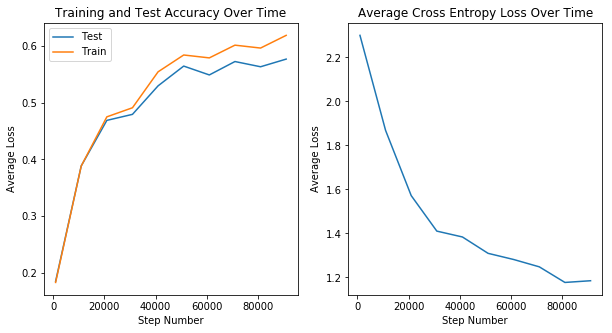

In [55]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(steps, test_accuracies, label = "Test")
ax[0].plot(steps, training_accuracies, label = "Train")
ax[0].set_xlabel("Step Number")
ax[0].set_ylabel("Average Loss")
ax[0].set_title("Training and Test Accuracy Over Time")
ax[0].legend()

ax[1].plot(steps, average_loss)
ax[1].set_title("Average Cross Entropy Loss Over Time")
ax[1].set_xlabel("Step Number")
ax[1].set_ylabel("Average Loss")

plt.savefig("NeuralNetResults.png")
plt.show()


In [44]:
def get_accuracy(images, labels):
    correct = 0
    total = 0
    for i, image in enumerate(images):
        if classify_example(image) == labels[i]:
            correct += 1
        total += 1
    return correct/total

def classify_example(image):
    transposed_image = np.transpose(image, (2,1,0))
    outputs = model(torch.Tensor(transposed_image[None,:,:,:]))
    probs = torch.squeeze(F.softmax(outputs, dim = 1))
    return torch.argmax(probs).item()

